In [1]:
%config InlineBackend.figure_format = "svg"

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing imports
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

# Progress bar
from tqdm import tqdm

## Import data

In [2]:
df = pd.read_csv("my_data/depth_pcd.csv")
df

,x,y,z,nx,ny,nz,cluster,tread,depth
0,-0.002940,-0.04294,0.290140,-0.326147,0.045403,0.944228,0,True,0.002565
1,0.138690,-0.05471,0.397650,0.826433,-0.048764,-0.560919,6,False,0.007607
2,0.146500,-0.00176,0.394075,0.804035,-0.001458,-0.594581,1,True,0.003624
3,0.044395,-0.00903,0.309410,-0.437302,0.408187,0.801343,1,True,0.002835
4,0.056847,-0.12176,0.330673,-0.613172,0.360063,0.703118,2,True,0.007728
...,...,...,...,...,...,...,...,...,...
43914,-0.108820,0.03000,0.269220,-0.033776,-0.142515,0.989216,4,True,0.002880
43915,-0.106470,0.03000,0.269310,-0.047981,-0.125475,0.990936,4,True,0.002954
43916,-0.128820,0.03000,0.269370,0.005268,-0.056899,0.998366,4,True,0.002503
43917,-0.127650,0.03000,0.269360,0.000712,-0.063930,0.997954,4,True,0.002557


## Plot depth histograms

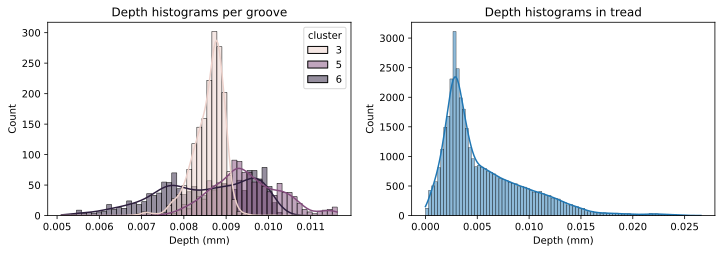

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Plot the data
axs[0].set_title("Depth histograms per groove")
sns.histplot(data=df.query("not tread"), x="depth", hue="cluster", kde=True, ax=axs[0])
axs[0].set_xlabel("Depth (mm)")
axs[1].set_title("Depth histograms in tread")
sns.histplot(data=df.query("tread"), x="depth", kde=True, ax=axs[1])
axs[1].set_xlabel("Depth (mm)")
plt.show()

From this plot, we can see that both the tread and the groove data have peaks at different depths. These peaks likely correspond to the tread and groove bottom depths, where the point cloud is more densely populated.

With this plot, we can clearly see that the peaks of the groove distributions represent the depth of the bottom of the grooves. They are close to normally distributed, but somewhat left skewed.

To calculate the depth of the groove bottoms, we need to subtract the groove depth by the tread depth.
We will do this in the following manner:
- Approximate histogram distributions for tread and grooves using KDE
- Calculate multiple estimates of their peak difference to get the peak difference distribution 
- Use the mean of the distribution as the predicted value of the difference
- Calculate prediction interval according to a certain significance level from the distribution

## Part 1: Approximating difference distribution per groove

In [4]:
# Define number of samples for the difference distribution
n_samples = 1000
peak_samples = 1000

# Initialize dictionary of difference samples
diff_df = {"groove": [], "diff": []}

# Get groove data, tread data and tread kde
bottom_df = df.query("not tread")
tread_df = df.query("tread")
tread_kde = gaussian_kde(tread_df.depth)

# Iterate each groove
for g in bottom_df.cluster.unique():
    
    # Filter groove bottom data
    groove_df = bottom_df.query(f"cluster == {g}")
    
    # Calculate depth KDE and samples for groove
    groove_kde = gaussian_kde(groove_df.depth)
    
    # Calculate multiple estimates for the peak difference
    tsamples, gsamples = [], []
    for _ in tqdm(range(peak_samples), desc="Finding peaks", total=peak_samples):
        
        # Sample from each KDE
        tread_samples = tread_kde.resample(size=n_samples).reshape(-1)
        groove_samples = groove_kde.resample(size=n_samples).reshape(-1)
        
        # Estimate new KDE from samples
        tkde = gaussian_kde(tread_samples)
        gkde = gaussian_kde(groove_samples)
        
        # Find peaks of each distribution
        xt = np.linspace(tread_samples.min(), tread_samples.max(), 100)
        xg = np.linspace(groove_samples.min(), groove_samples.max(), 100)
        tpeaks, _ = find_peaks(tkde(xt))
        gpeaks, _ = find_peaks(gkde(xg))
        
        # Calculate maximum peaks
        tpeaks_v, gpeaks_v = tkde(xt)[tpeaks], gkde(xg)[gpeaks]
        tpeak, gpeak = np.argmax(tpeaks_v), np.argmax(gpeaks_v)
        tpeak, gpeak = xt[tpeak], xg[gpeak]
        
        # Add to peak list
        tsamples.append(tpeak)
        gsamples.append(gpeak)
    
    # Convert peaks to arrays
    tsamples, gsamples = np.array(tsamples), np.array(gsamples)
    
    # Calculate difference samples
    diff_samples = gsamples - tsamples
    
    # Calculate sample difference and add data to difference dict
    grooves = g * np.ones(shape=peak_samples, dtype="int64")
    diff_df["groove"].append(grooves)
    diff_df["diff"].append(diff_samples)
    
# Concatenate all samples
diff_df["groove"] = np.concatenate(diff_df["groove"])
diff_df["diff"] = np.concatenate(diff_df["diff"])
    
# Turn dictionary into dataframe
diff_df = pd.DataFrame(diff_df)
diff_df

Finding peaks: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.45it/s]


,groove,diff
0,6,0.005767
1,6,0.005266
2,6,0.005458
3,6,0.005184
4,6,0.005545
...,...,...
2995,5,0.007593
2996,5,0.008113
2997,5,0.007742
2998,5,0.008170


Now let's plot the distribution of the depth difference for each groove:

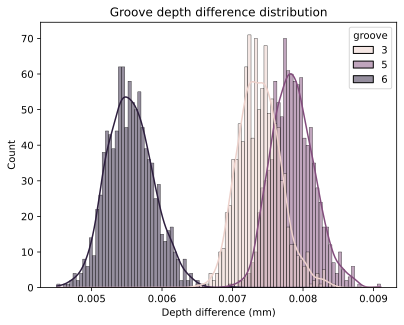

In [9]:
plt.title("Groove depth difference distribution")
sns.histplot(data=diff_df, x="diff", bins=100, hue="groove", kde=True)
plt.xlabel("Depth difference (mm)")
plt.show()

Now we can estimate the groove depth as the mean of the distribution.

Given a significance $\alpha$, we define the prediction interval as the quantiles $\alpha/2$ and $1 - \alpha/2$:

In [6]:
# Get the mean per goove
mean_df = diff_df.rename(columns={"diff": "mean"}).groupby("groove", as_index=False).mean()
mean_df

,groove,mean
0,3,0.007385
1,5,0.007856
2,6,0.005550


In [7]:
# Define significance
significance = 0.05

# Get the prediction quantiles
interval_df = diff_df.rename(columns={"diff": "lower"})
interval_df["upper"] = interval_df["lower"]

# Get the quantiles
interval_df = interval_df.groupby("groove", as_index=False).agg({
    "lower": lambda x: np.quantile(x, significance/2),
    "upper": lambda x: np.quantile(x, 1-significance/2)
})
interval_df

,groove,lower,upper
0,3,0.006864,0.008021
1,5,0.007344,0.008521
2,6,0.004951,0.006220


Now let's plot these regions along with their distributions:

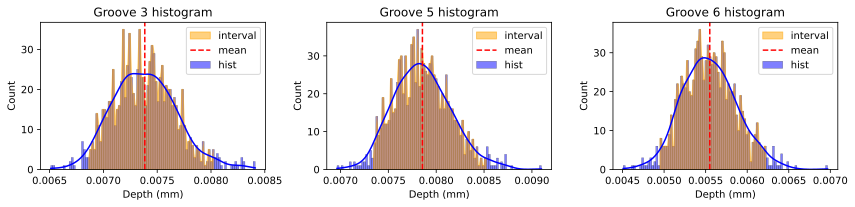

In [8]:
# Get grooves
grooves = mean_df.groove.unique()

# Define axis and figure
fig, axs = plt.subplots(1, grooves.shape[0], figsize=(12, 3))

# Iterate grooves
for ax, g in zip(axs, grooves):
    
    # Calculate histogram of data
    hist, bins = np.histogram(diff_df.query(f"groove == {g}")["diff"], bins=100)
    
    # Calculate x and y data for fill between plot
    x_min = interval_df.query(f"groove == {g}").lower
    x_max = interval_df.query(f"groove == {g}").upper
    x = np.linspace(x_min, x_max, 100).reshape(-1)
    y_min = np.zeros(x.shape[0])
    y_max = hist[np.digitize(x, bins)-1]
    
    # Get mean
    x_mean = mean_df.loc[mean_df["groove"] == g, "mean"].values[0]
    
    # Make the plot
    ax.set_title(f"Groove {g} histogram")
    sns.histplot(data=diff_df.query(f"groove == {g}"), x="diff", label="hist", kde=True, color="blue", ax=ax, bins=100)
    ax.fill_between(x, y_min, y_max, label="interval", color="orange", alpha=0.5)
    ax.axvline(x_mean, label="mean", color="red", linestyle="--")
    ax.set_xlabel("Depth (mm)")
    ax.legend()
    
plt.tight_layout()
plt.show()    

Therefore, from this analysis, we can verify that the depth of the grooves are very likely to be above $3$ mm, which implies that its performance has likely not fallen off.